# Question answer project

The aim of the project is to create a question answer algorithm using a paragraph and a question as entries, and providing a correct answer. Such a model would be interesting in an encyclopedic website like Wikipedia, as it would analyse 'proper pages' paragraphs in parallel to answer quickly our question. Therefore, having a model doing this task can help curious person to increase their knowledge.

Our model will be constituted with an embedding layer, followed by a LSTM and two fully connected layers to do two classification to know the position of both starting and ending tokens of the answer in the text of the context.

A nice idea for further steps is to replace the LSTM with an encoder with two attention layers (one for the paragraph and one for the question). And to test the model on its performances and grammatical aspects. And use bigger models such as Transformers or T5.

The dataset that we will use is the SQUAD 2.0 from Stanford University.

# Installations & Data Loading

In [114]:
import pandas as pd
import numpy as np
import json
import math
import torch
import matplotlib.pyplot as plt

import collections
from nltk.util import ngrams
from nltk.corpus import stopwords
import nltk
nltk.download('stopwords')

from tqdm import tqdm
from nltk.tokenize import TweetTokenizer
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torchtext.vocab import GloVe, vocab, FastText

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.autograd as autograd
from collections import Counter

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [115]:
! wget -c https://rajpurkar.github.io/SQuAD-explorer/dataset/train-v2.0.json

--2022-04-24 16:11:24--  https://rajpurkar.github.io/SQuAD-explorer/dataset/train-v2.0.json
Resolving rajpurkar.github.io (rajpurkar.github.io)... 185.199.108.153, 185.199.109.153, 185.199.110.153, ...
Connecting to rajpurkar.github.io (rajpurkar.github.io)|185.199.108.153|:443... connected.
HTTP request sent, awaiting response... 416 Range Not Satisfiable

    The file is already fully retrieved; nothing to do.



# Data Representation
Let's transform the data to make it compatible with our code.

In [116]:
def squad_json_to_dataframe_train(input_file_path, record_path = ['data','paragraphs','qas','answers'],
                           verbose = 1):
    """
    input_file_path: path to the squad json file.
    record_path: path to deepest level in json file default value is
    ['data','paragraphs','qas','answers']
    verbose: 0 to suppress it default is 1
    """
    if verbose:
        print("Reading the json file")    
    file = json.loads(open(input_file_path).read())
    if verbose:
        print("processing...")
    # parsing different level's in the json file
    js = pd.io.json.json_normalize(file , record_path )
    m = pd.io.json.json_normalize(file, record_path[:-1] )
    r = pd.io.json.json_normalize(file,record_path[:-2])
    
    #combining it into single dataframe
    idx = np.repeat(r['context'].values, r.qas.str.len())
    ndx  = np.repeat(m['id'].values,m['answers'].str.len())
    m['context'] = idx
    js['q_idx'] = ndx
    main = pd.concat([ m[['id','question','context']].set_index('id'),js.set_index('q_idx')],1,sort=False).reset_index()
    main['c_id'] = main['context'].factorize()[0]
    if verbose:
        print("shape of the dataframe is {}".format(main.shape))
        print("Done")
    return main

In [117]:
# Obtaining data in pandas dataframe
input_file_path = 'train-v2.0.json'
record_path = ['data','paragraphs','qas','answers']
data = squad_json_to_dataframe_train(input_file_path=input_file_path,record_path=record_path)

Reading the json file
processing...


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: FutureWarning: pandas.io.json.json_normalize is deprecated, use pandas.json_normalize instead
  from ipykernel import kernelapp as app
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: FutureWarning: pandas.io.json.json_normalize is deprecated, use pandas.json_normalize instead
  app.launch_new_instance()
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: FutureWarning: pandas.io.json.json_normalize is deprecated, use pandas.json_normalize instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:24: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only


shape of the dataframe is (130319, 6)
Done


In [118]:
data.head(3)

,index,question,context,text,answer_start,c_id
0,56be85543aeaaa14008c9063,When did Beyonce start becoming popular?,Beyoncé Giselle Knowles-Carter (/biːˈjɒnseɪ/ b...,in the late 1990s,269.0,0
1,56be85543aeaaa14008c9065,What areas did Beyonce compete in when she was...,Beyoncé Giselle Knowles-Carter (/biːˈjɒnseɪ/ b...,singing and dancing,207.0,0
2,56be85543aeaaa14008c9066,When did Beyonce leave Destiny's Child and bec...,Beyoncé Giselle Knowles-Carter (/biːˈjɒnseɪ/ b...,2003,526.0,0


In [119]:
data.columns

Index(['index', 'question', 'context', 'text', 'answer_start', 'c_id'], dtype='object')

In [120]:
data.shape

(130319, 6)

# Data Cleaning

Let's look if we have duplicates in our dataset

In [121]:
len(data[data.duplicated(keep=False)])

0

It seems that we do not have any duplicates. Can we find identical question-context-answer with identical features in the dataset? Let's try to check if we can have two identical question-context-answer with two different ids.

In [122]:
# Do we have duplicates?
col_to_check = ['question', 'context', 'text', 'answer_start', 'c_id']
print(data[data[col_to_check].duplicated(keep=False)].shape)
data[data[col_to_check].duplicated(keep=False)].head(5)

(52, 6)


,index,question,context,text,answer_start,c_id
251,56be9bb83aeaaa14008c915c,When did Beyonce have her first child?,"On January 7, 2012, Beyoncé gave birth to her ...","January 7, 2012",3.0,20
255,56bfa087a10cfb14005511d9,When did Beyonce have her first child?,"On January 7, 2012, Beyoncé gave birth to her ...","January 7, 2012",3.0,20
916,56cf66734df3c31400b0d714,What year did Chopin leave Warsaw?,"In 1827, soon after the death of Chopin's youn...",1830,329.0,77
920,56d3123b59d6e41400146205,What year did Chopin leave Warsaw?,"In 1827, soon after the death of Chopin's youn...",1830,329.0,77
1061,56cfdb3e234ae51400d9bf7f,What was the name of Liszt's mistress?,Although the two displayed great respect and a...,Marie d'Agoult,1168.0,90


In [123]:
data[data['question']=="What year did Chopin leave Warsaw?"]

,index,question,context,text,answer_start,c_id
916,56cf66734df3c31400b0d714,What year did Chopin leave Warsaw?,"In 1827, soon after the death of Chopin's youn...",1830,329.0,77
920,56d3123b59d6e41400146205,What year did Chopin leave Warsaw?,"In 1827, soon after the death of Chopin's youn...",1830,329.0,77


This is the case, we have several duplicates, let's remove them.

In [124]:
#Removing duplicates
data = data.drop_duplicates(subset=col_to_check, keep='first')

Do we have Nan or others weird values?

In [125]:
data.describe(include='all')

,index,question,context,text,answer_start,c_id
count,130293,130293,130293,86798,86798.000000,130293.000000
unique,130293,130217,19029,64763,NaN,NaN
top,56be85543aeaaa14008c9063,In what year did World War II start?,"In 1853, Victoria gave birth to her eighth chi...",three,NaN,NaN
freq,1,3,30,231,NaN,NaN
mean,NaN,NaN,NaN,NaN,319.810791,9847.873792
std,NaN,NaN,NaN,NaN,266.383226,5364.786633
min,NaN,NaN,NaN,NaN,0.000000,0.000000
25%,NaN,NaN,NaN,NaN,111.000000,5627.000000
50%,NaN,NaN,NaN,NaN,262.000000,9965.000000
75%,NaN,NaN,NaN,NaN,468.000000,14459.000000


Looking at the above table, we can see that we don't have any missing values for 'index', 'question', 'context'. But we have a lot of missing values for the answers.

Interstingly, we have still some questions that are the same. Let's look at this in more detail

In [126]:
#Same question and context data
data[data[['question','context']].duplicated(keep=False)]

,index,question,context,text,answer_start,c_id
1226,56cf5433aab44d1400b88ff1,Who orchestrated Chopiniana?,Chopin's music was used in the 1909 ballet Cho...,Alexander Glazunov,106.0,108
1230,56d3a9bb2ccc5a1400d82ddc,Who orchestrated Chopiniana?,Chopin's music was used in the 1909 ballet Cho...,Alexander Glazunov.,106.0,108
1255,56cfe7f4234ae51400d9c060,Where was Chopin's last public performance?,Chopin made his last public appearance on a co...,Guildhall,73.0,112
1258,56d375b859d6e4140014646b,Where was Chopin's last public performance?,Chopin made his last public appearance on a co...,London's Guildhall,64.0,112
1285,56cfeae2234ae51400d9c0b9,Where was Chopin's funeral held?,"The funeral, held at the Church of the Madelei...",Church of the Madeleine,25.0,117
...,...,...,...,...,...,...
126760,5aced07232bba1001ae4b538,Why did Wilson rotate officers between communi...,"In the United States, August Vollmer introduce...",NaN,NaN,18530
129292,5734465d879d6814001ca466,Who are the only remaining full-time hunter-ga...,Hunter-gathering lifestyles remained prevalent...,the Hadza of Tanzania,625.0,18883
129295,5735e8736c16ec1900b9288a,Who are the only remaining full-time hunter-ga...,Hunter-gathering lifestyles remained prevalent...,Hadza of Tanzania,629.0,18883
129520,57345181879d6814001ca509,What percentage of Americans actually hunted a...,Hunting in the United States is not associated...,just six percent,251.0,18899


We can see that for some identical question/context, we can obtain different answers values (the are almost the same, except that they are composed of an extra '.', or extra useless words like 'the').
As we are lazy to clean this part of data, and as it concerned only 76 rows on the 130 000 available, let's remove all this data.

In [127]:
#Removing duplicates
data = data.drop_duplicates(subset=['question','context'], keep=False)

In [128]:
#Same question
data[data['question'].duplicated(keep=False)].head(10)

,index,question,context,text,answer_start,c_id
786,56d1cd98e7d4791d009021e6,In what year did Chopin become a French citizen?,At the age of 21 he settled in Paris. Thereaft...,1835,415.0,67
982,56cf6d3e4df3c31400b0d783,In what year did Chopin become a French citizen?,Chopin arrived in Paris in late September 1831...,1835,251.0,82
1882,56cc858b6d243a140015efec,What does DRM stand for?,The iPod line can play several audio file form...,Digital Rights Management,729.0,242
10723,5ad0ccaa645df0001a2d03ac,On what date was the 2010 Human Development Re...,The 2014 Human Development Report by the Unite...,NaN,NaN,1712
10749,56de4347cffd8e1900b4b741,On what date was the 2010 Human Development Re...,The 2010 Human Development Report by the Unite...,"November 4, 2010",92.0,1718
10992,56de4fd0cffd8e1900b4b7f4,When did the USSR dissolve?,Italy became a major industrialized country ag...,1991,474.0,1759
17651,5ad12b14645df0001a2d1070,What does IPM stand for?,"Soon, Laemmle and other disgruntled nickelodeo...",NaN,NaN,3018
17984,5ad165eb645df0001a2d19ac,What happened in 1970?,"In the early 1950s, Universal set up its own d...",NaN,NaN,3056
20217,56e792e237bdd419002c417f,When did Japan invade Manchuria?,"In 1937, the Empire of Japan started a full-sc...",1931,96.0,3378
23864,56f970019b226e1400dd145e,What is copra?,"On September 15, 2007, Witon Barry (of the Tob...",the meat of the coconut,354.0,4059


We can have the same question for different context. We keep this data.

In [129]:
data.describe(include='all')

,index,question,context,text,answer_start,c_id
count,130217,130217,130217,86747,86747.000000,130217.000000
unique,130217,130179,19029,64726,NaN,NaN
top,56be85543aeaaa14008c9063,In what year did World War II start?,"In 1853, Victoria gave birth to her eighth chi...",three,NaN,NaN
freq,1,3,30,231,NaN,NaN
mean,NaN,NaN,NaN,NaN,319.834830,9847.745609
std,NaN,NaN,NaN,NaN,266.370408,5364.512350
min,NaN,NaN,NaN,NaN,0.000000,0.000000
25%,NaN,NaN,NaN,NaN,111.000000,5627.000000
50%,NaN,NaN,NaN,NaN,262.000000,9964.000000
75%,NaN,NaN,NaN,NaN,468.000000,14459.000000


Having a lot of missing values in the answers. Our choice was to keep the lines without answers. And to add an extra neuron for classification for no Answer situation. The beginning of answer will be set as -1, and the answer end will also be set as -1.

Now we want to look the answer_start feature. Is it the word position or the character position?
We will look to an example to have the answer.

In [130]:
data[['question', 'context', 'text', 'answer_start']].iloc[0]

question                 When did Beyonce start becoming popular?
context         Beyoncé Giselle Knowles-Carter (/biːˈjɒnseɪ/ b...
text                                            in the late 1990s
answer_start                                                269.0
Name: 0, dtype: object

In [131]:
#Line of code to show string starting from cher n°269
data['context'].iloc[0][269:]

'in the late 1990s as lead singer of R&B girl-group Destiny\'s Child. Managed by her father, Mathew Knowles, the group became one of the world\'s best-selling girl groups of all time. Their hiatus saw the release of Beyoncé\'s debut album, Dangerously in Love (2003), which established her as a solo artist worldwide, earned five Grammy Awards and featured the Billboard Hot 100 number-one singles "Crazy in Love" and "Baby Boy".'

The answer_start field is currently representing the character position of the beginning of the answer. In our case, we will prefer the word number position.

# Let's retrieve the word positions of the answer: starting & ending

For this purpose, we will use a tokenizer, and count the number of words before the answer start. And add the answer to get the word position for the answer.

In [132]:
tok = TweetTokenizer()

In [133]:
def AnswerTokenStart(row):
    if (math.isnan(row['answer_start'])):
        return -1
    return len(tok.tokenize(row['context'][:int(row['answer_start'])].lower().strip()))

In [134]:
def AnswerTokenEnd(row):
    if (math.isnan(row['answer_start'])):
        return -1
    return row['answer_beg'] + len(tok.tokenize(row['text'].lower().strip()))

In [135]:
data['answer_beg'] = data.apply(lambda row: AnswerTokenStart(row), axis=1)
data['answer_end'] = data.apply(lambda row: AnswerTokenEnd(row), axis=1)

In [136]:
data[['answer_beg', 'answer_end']].iloc[0]

answer_beg    52
answer_end    56
Name: 0, dtype: int64

In [137]:
tok.tokenize(data['context'].iloc[0].lower().strip())[52:56]

['in', 'the', 'late', '1990s']

# Data Visualisation: looking at our dataset

It's time to look at the number of tokens in question, context and answers, to get more insigth about dataset

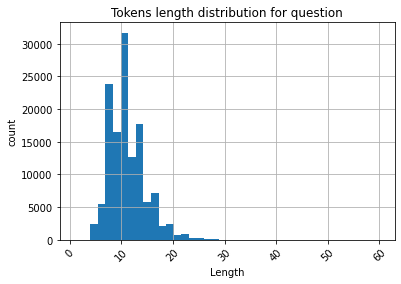

In [138]:
# Question token length
data.question.apply(lambda x: len(tok.tokenize(x.lower().strip()))).hist(bins=40)
plt.title('Tokens length distribution for question')
plt.xticks(rotation=45)
plt.xlabel('Length')
plt.ylabel('count')
plt.show()

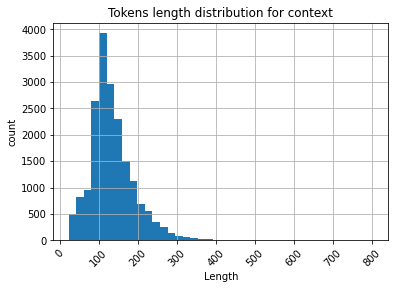

In [139]:
# Context token length
# Removing duplicates as we have many questions for a single context
data.context.drop_duplicates().apply(lambda x: len(tok.tokenize(x.lower().strip()))).hist(bins=40)
plt.title('Tokens length distribution for context')
plt.xticks(rotation=45)
plt.xlabel('Length')
plt.ylabel('count')
plt.show()

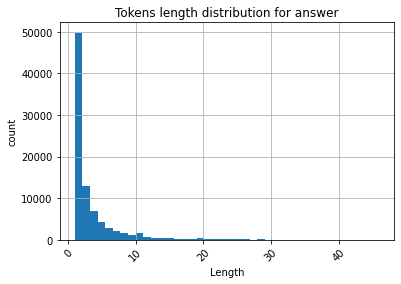

In [140]:
# Answer token length when available
data.text.dropna().apply(lambda x: len(tok.tokenize(str(x).lower().strip()))).hist(bins=40)
plt.title('Tokens length distribution for answer')
plt.xticks(rotation=45)
plt.xlabel('Length')
plt.ylabel('count')
plt.show()

Looking at the tooken length of question and context, we can see that most of the questions have less than 20 tokkens, and most of the context have less than 280 tokkens. Therefore, we can take 300 tokkens in entry of the model: all question tokken, followed by the tokkens of context until we reach 300 (or add padding, if we don't have enougth tokken).

Concerning, the answer, we can see that we have a lot a single word answer: by looking some answers, we can see that it can be names, dates (year), place...

Let's show how many questions have an answer VS how many don't.

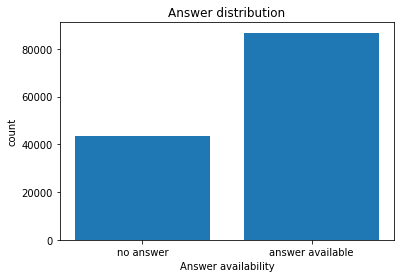

In [141]:
#Let's plot the distribution of answers
plt.bar(['no answer', 'answer available'], [data['text'].isna().sum(), len(data['text']) - data['text'].isna().sum()])
plt.title('Answer distribution')
plt.xlabel('Answer availability')
plt.ylabel('count')
plt.show()

Let's look at the number of questions per context distribution

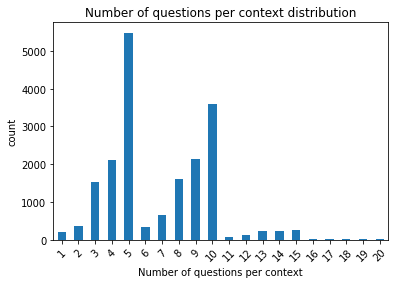

In [142]:
data.groupby(by=['c_id']).count()['question'].value_counts().sort_index(ascending=True)[:20].plot.bar()
plt.title('Number of questions per context distribution')
plt.xticks(rotation=45)
plt.xlabel('Number of questions per context')
plt.ylabel('count')
plt.show()

The distribution of question is a little bit weird. So far we don't have any explanation for this.

Word frequency for questions

In [143]:
# Function to count the most frequent n-grams
def ngram(flat_list,n):
    ngram= ngrams(flat_list, n)
    return collections.Counter(ngram).most_common()

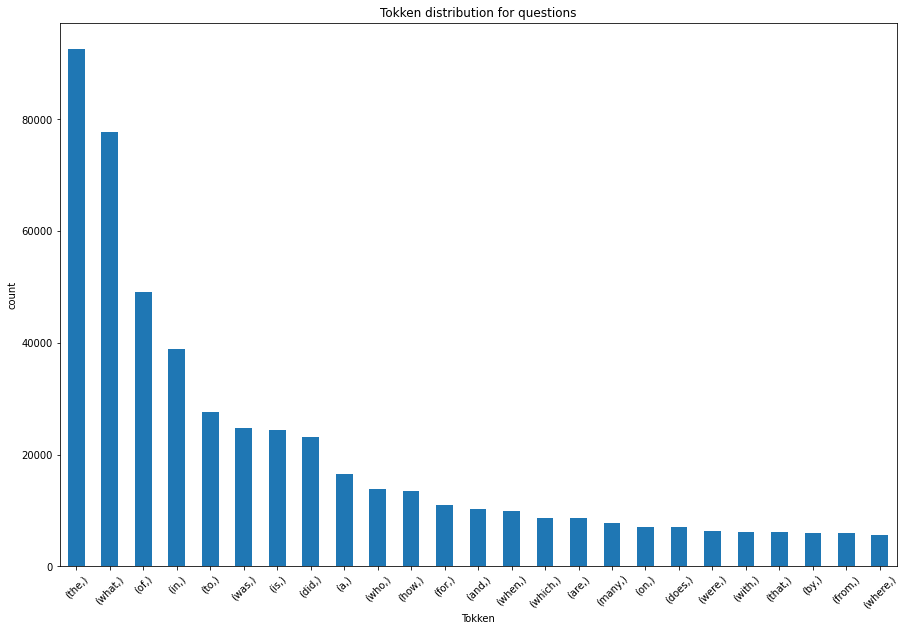

In [144]:
# Define a list of words that we want to remove from our results
stoplist = ['?', ',']
# Converting the question DataFrame into a list
question_list = [q for q in data['question']]
# Convert each word in tokken according to the tokenizer
lemmatized_question=[]
for question in question_list:
    tokens = tok.tokenize(question.lower().strip())
    lemmatized_question.append(tokens)
# Removing stop tokkens from our results
no_stop = [[t for t in i if t not in stoplist] for i in lemmatized_question]
# Flattening the list of tokkens
flat_list=[]
for sublist in no_stop:
    for item in sublist:
        flat_list.append(item)

# Printing the 25 most common words
dist_df=pd.DataFrame(ngram(flat_list,1)[:25])
dist_df.plot.bar(x=0,y=1, rot=90,figsize=(15,10), legend=None)
plt.title('Tokken distribution for questions')
plt.xticks(rotation=45)
plt.xlabel('Tokken')
plt.ylabel('count')
plt.show()

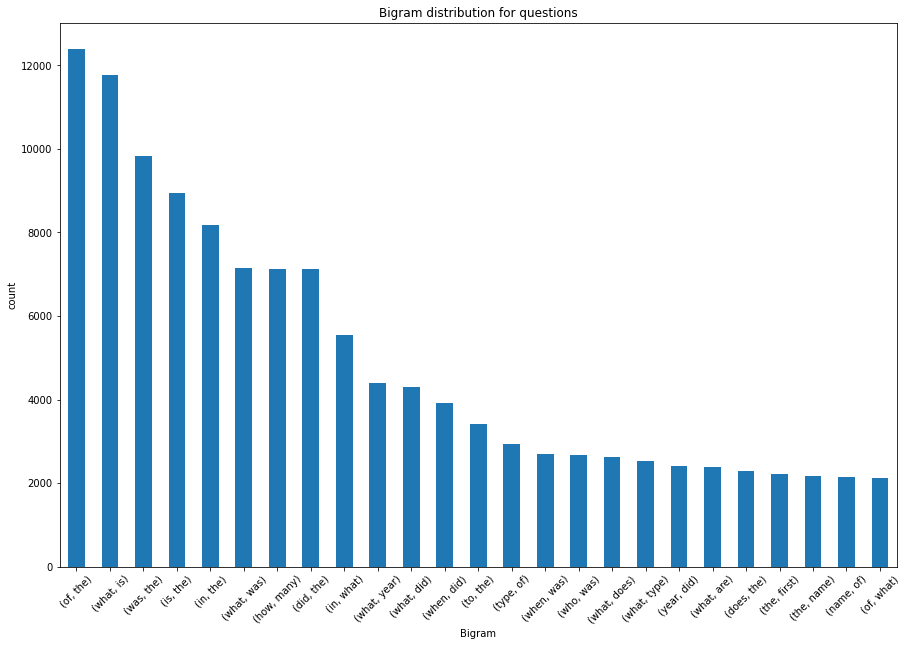

In [145]:
# Printing the 25 most common bi-grams
dist_df=pd.DataFrame(ngram(flat_list,2)[:25])
dist_df.plot.bar(x=0,y=1, rot=90,figsize=(15,10), legend=None)
plt.title('Bigram distribution for questions')
plt.xticks(rotation=45)
plt.xlabel('Bigram')
plt.ylabel('count')
plt.show()

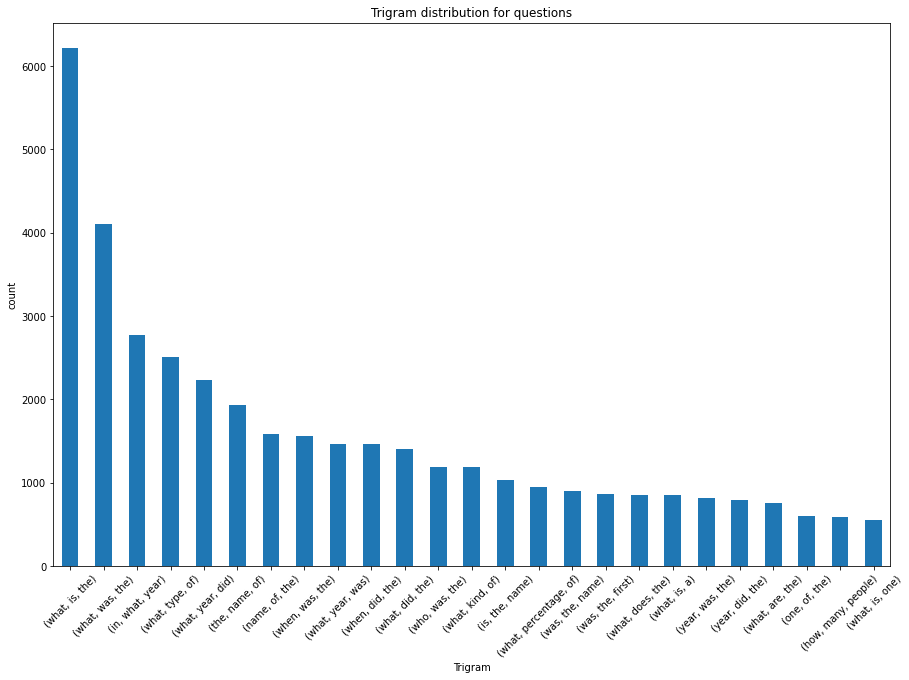

In [146]:
# Printing the 25 most common tri-grams
dist_df=pd.DataFrame(ngram(flat_list,3)[:25])
dist_df.plot.bar(x=0,y=1, rot=90,figsize=(15,10), legend=None)
plt.title('Trigram distribution for questions')
plt.xticks(rotation=45)
plt.xlabel('Trigram')
plt.ylabel('count')
plt.show()

What are the question tokkens that appear the most?

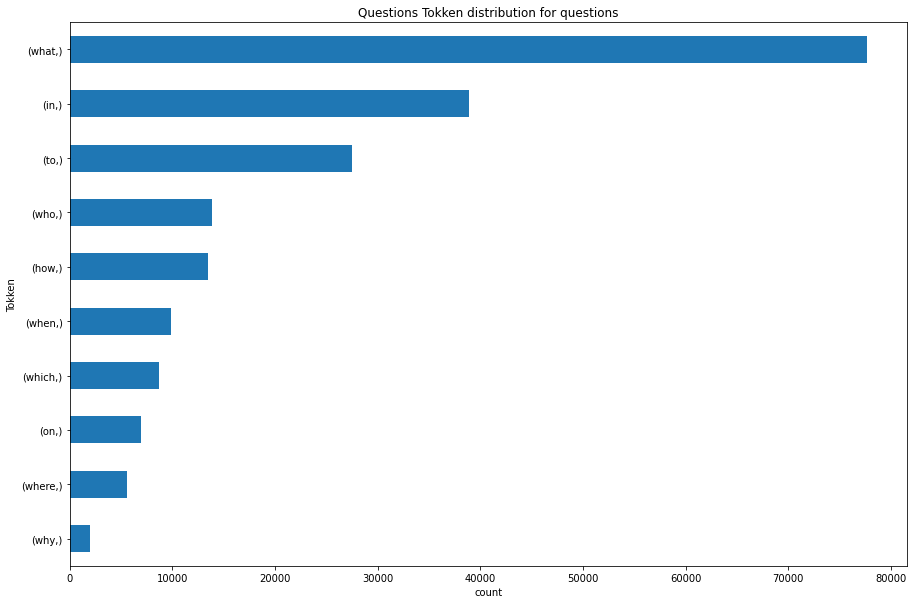

In [147]:
# List of words that we are interested in
qlist = ['what', 'how', 'who', 'when', 'which', 'where', 'why', 'in', 'on', 'to']
# Keeping tokkens we are interested in
no_stop = [[t for t in i if t in qlist] for i in lemmatized_question]
flat_list=[]
for sublist in no_stop:
    for item in sublist:
        flat_list.append(item)

# Printing the tokkens
dist_df=pd.DataFrame(ngram(flat_list,1)).sort_index(ascending=False)
dist_df.plot.barh(x=0,y=1, rot=90,figsize=(15,10), legend=None)
plt.title('Questions Tokken distribution for questions')
plt.yticks(rotation=0)
plt.xlabel('count')
plt.ylabel('Tokken')
plt.show()

Looking at the last graph, we can see that, we have mostly 'what' type of question. This is also highlighted with the 'what is' bigram being the most frequent one after bigram 'of the'.
Looking at the trigrams, we can see that we have a lot of similar question such as: In what year, what type of, what year was, etc.

Word frequency for context

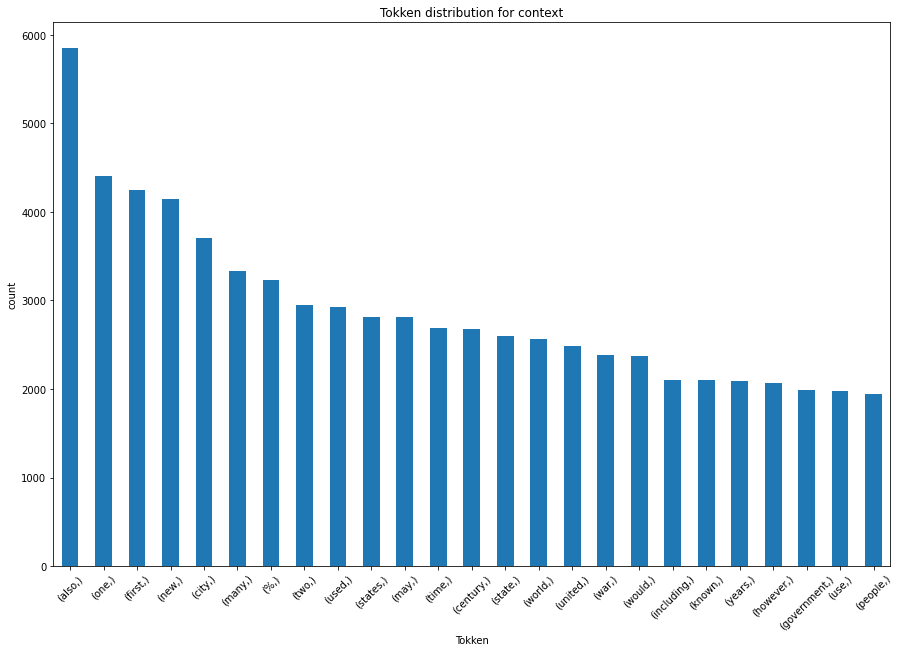

In [148]:
# Define a list of words that we want to remove from our results
stoplist = stopwords.words('english')
stoplist.extend(['.',',',')','(', '?', '"', ';', ':', '–', "'", '[', ']', '-'])
# Converting the context DataFrame into a list
context_list = [q for q in data.context.drop_duplicates()]
# Convert each word in tokken according to the tokenizer
lemmatized_context=[]
for context in context_list:
    tokens = tok.tokenize(context.lower().strip())
    lemmatized_context.append(tokens)
# Removing stop tokkens from our results
no_stop = [[t for t in i if t not in stoplist] for i in lemmatized_context]
# Flattening the list of tokkens
flat_list=[]
for sublist in no_stop:
    for item in sublist:
        flat_list.append(item)

# Printing the 25 most common words
dist_df=pd.DataFrame(ngram(flat_list,1)[:25])
dist_df.plot.bar(x=0,y=1, rot=90,figsize=(15,10), legend=None)
plt.title('Tokken distribution for context')
plt.xticks(rotation=45)
plt.xlabel('Tokken')
plt.ylabel('count')
plt.show()

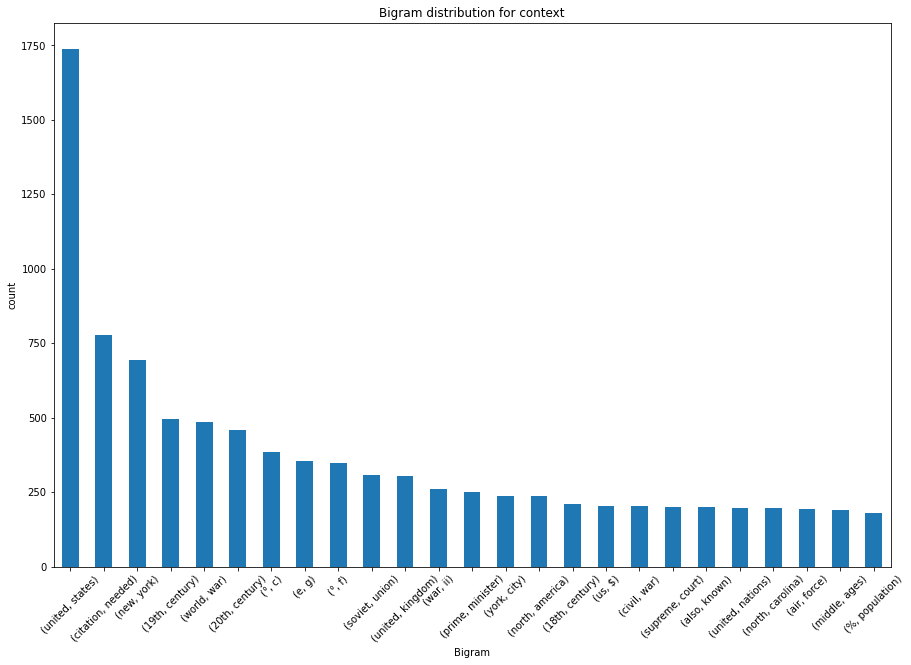

In [149]:
# Printing the 25 most common bigrams
dist_df=pd.DataFrame(ngram(flat_list,2)[:25])
dist_df.plot.bar(x=0,y=1, rot=90,figsize=(15,10), legend=None)
plt.title('Bigram distribution for context')
plt.xticks(rotation=45)
plt.xlabel('Bigram')
plt.ylabel('count')
plt.show()

Looking at the bigrams for context, we can see 'united states', 'new york' or 'north america' which are a lot of US bigrams. Maybe saying that a lot of articles are related with USA.

We can also see some metric such as °C, °f, or % population.
And some dates such as 19th century, 20th century (maybe saying that the context are mostly from recent history (ex: Beyonce))

Citation needed is an interesting bigram because it appears a lot in the Wikipedia pages when a citation is really needed to highlight a piece of information. This bigram should be removed in the corpus, but this will be left for the next steps.

# Let's create a simple model, in which in entry we concatenate the question with the context

In this section, we want to combine the question and the context in a single entry for our model. The entry will be composed of 
```
[question tokens] + [end of question token] + [context tokens] + [pading tokens]
```
And it will be converted into vectors with the Glove pretrained embedings.

Let's first download the GloVe pretrained vectors.

In [150]:
pretrained_vectors = GloVe(name="6B", dim='50')

In [151]:
print(pretrained_vectors['beyonce'])

tensor([-0.0937,  0.5236,  0.2702,  0.7983, -0.4120,  0.0445,  0.3991,  0.0044,
         0.8581,  1.9740,  0.1814,  0.4373, -0.3023,  0.6262, -0.0643,  0.2984,
        -0.0245, -1.1808,  0.5135, -0.1783, -0.6956,  0.9800,  1.1588,  0.1510,
         0.0563, -0.0074, -1.4715, -0.3011, -1.1525, -1.4750, -0.2914,  0.7519,
         0.5445,  0.4029,  0.5384, -1.0918,  0.7068, -0.5869, -0.3682, -0.5314,
        -0.5449,  0.9530, -0.5681, -0.4658,  0.5187, -0.5819,  0.0684, -1.9778,
        -0.6726,  0.8330])


In [152]:
print(pretrained_vectors[')'])

tensor([-2.8314e-01,  1.0028e+00,  1.4746e-01,  2.2262e-01,  7.0985e-03,
         2.3108e-01,  5.7082e-01, -1.2767e+00, -7.2415e-01, -7.5270e-01,
         5.2624e-01,  3.9498e-01,  1.8922e-03, -3.9396e-01,  4.4859e-01,
        -1.9057e-02,  6.8143e-02,  4.5082e-01, -1.2849e+00,  6.8088e-01,
        -4.8318e-01, -4.5829e-01,  8.5504e-01,  4.7712e-01, -1.6152e-01,
        -7.4784e-01,  4.0742e-01, -9.7385e-01, -7.2580e-01, -1.7232e-01,
         3.8901e+00, -4.6535e-01, -6.1925e-01,  6.3584e-01, -2.0339e-01,
        -8.0612e-02,  6.4959e-01, -5.1208e-01,  9.1193e-01,  3.6208e-02,
         1.0099e+00,  1.8802e-01,  5.9359e-01, -6.1313e-01, -6.6839e-01,
         6.7479e-01,  4.0625e-01, -6.9590e-01,  1.4553e-01,  3.7339e-01])


Let's look how to convert a sentence (here a question of our datset) into token number being a key for the embeding using a pretrained_vectors dictionnary.

In [153]:
pretrained_vocab = vocab(pretrained_vectors.stoi)
unk_token = "<unk>"
unk_index = 0
pad_token = '<pad>'
pad_index = 1
eoq_token = '<eoq>'
eoq_index = 2
pretrained_vocab.insert_token("<unk>",unk_index)
pretrained_vocab.insert_token("<pad>", pad_index)
pretrained_vocab.insert_token("<eoq>", eoq_index)
#this is necessary otherwise it will throw runtime error if OOV token is queried 
pretrained_vocab.set_default_index(unk_index)
pretrained_embeddings = pretrained_vectors.vectors
pretrained_embeddings = torch.cat((torch.ones(1,pretrained_embeddings.shape[1]),
                                   torch.zeros(1,pretrained_embeddings.shape[1]),
                                   torch.ones(1,pretrained_embeddings.shape[1])*10,
                                   pretrained_embeddings))
pretrained_embeddings.size()

torch.Size([400003, 50])

In [154]:
pretrained_embeddings[pretrained_vocab.get_stoi()['<eoq>']]

tensor([10., 10., 10., 10., 10., 10., 10., 10., 10., 10., 10., 10., 10., 10.,
        10., 10., 10., 10., 10., 10., 10., 10., 10., 10., 10., 10., 10., 10.,
        10., 10., 10., 10., 10., 10., 10., 10., 10., 10., 10., 10., 10., 10.,
        10., 10., 10., 10., 10., 10., 10., 10.])

In [155]:
print(data['question'][0].lower().strip())

when did beyonce start becoming popular?


In [156]:
question_tokens = tok.tokenize(data['question'][0].lower().strip())
print(question_tokens)

['when', 'did', 'beyonce', 'start', 'becoming', 'popular', '?']


In [157]:
question_tokens_sos = tok.tokenize(data['question'][0].lower().strip()) + ['<eoq>']
print(question_tokens_sos)

['when', 'did', 'beyonce', 'start', 'becoming', 'popular', '?', '<eoq>']


In [158]:
[pretrained_vocab.get_stoi()[token] if token in pretrained_vocab.get_stoi() else pretrained_vocab.get_stoi()['<unk>'] for token in question_tokens_sos]

[63, 121, 31264, 467, 1665, 816, 190, 2]

Let's create the function to concatenate the question and the context, while transforming the tokens into indexes.

In [159]:
def concat_qc(row,  vocab_stoi = pretrained_vocab.get_stoi(), max_length = 300):
  '''
  This function returns the words indexes to retrieve an embedded torch_tensor of format q + <eoq> + c + <pad>
  '''
  question = [vocab_stoi[token] if token in vocab_stoi else vocab_stoi['<unk>'] for token in tok.tokenize(row['question'].lower().strip())]
  if len(question) < max_length:
    concat_text = question + [vocab_stoi['<eoq>']]
  else:
    return question[:max_length]
  context = [vocab_stoi[token] if token in vocab_stoi else vocab_stoi['<unk>'] for token in tok.tokenize(row['context'].lower().strip())]
  nb_tokens = len(question) + len(context) + 1
  if nb_tokens < max_length:
    return concat_text + context + [ vocab_stoi['<pad>'] for i in range(nb_tokens, max_length) ]
  elif nb_tokens > max_length:
    return concat_text + context[:(max_length - len(question) - 1)]
  else:
    return concat_text + context

In [160]:
print(concat_qc(data.iloc[0]))

[63, 121, 31264, 467, 1665, 816, 190, 2, 47038, 45745, 0, 25, 276, 0, 276, 0, 26, 25, 381, 443, 411, 3, 2900, 26, 16, 31, 142, 2228, 3, 9637, 3, 386, 1940, 7, 2892, 4, 381, 7, 1075, 8, 2000, 3, 747, 3, 69, 1791, 8, 919, 4101, 7, 5367, 5675, 21, 9, 966, 3, 7, 488, 6, 3154, 8, 0, 290, 2258, 21, 412, 2228, 5, 1913, 1163, 1558, 281670, 0, 966, 4, 1766, 23, 73, 631, 3, 27886, 18367, 3, 0, 131, 304, 50, 5, 0, 0, 20666, 1751, 505, 5, 66, 81, 4, 46, 13694, 824, 0, 715, 5, 0, 1606, 599, 3, 15311, 8, 837, 25, 784, 26, 3, 44, 986, 73, 21, 9, 3521, 2133, 1978, 3, 1772, 176, 8472, 1544, 7, 1980, 0, 5157, 1629, 560, 22715, 2320, 10, 5580, 8, 837, 10, 7, 10, 2234, 1608, 10, 4, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,

In [161]:
max_length = 300
res = []
for index, row in tqdm(data.iterrows(), total=data.shape[0]):
    res.append(concat_qc(row, max_length=max_length))
data['train'] = res

100%|██████████| 130217/130217 [01:21<00:00, 1605.86it/s]


In [162]:
data

,index,question,context,text,answer_start,c_id,answer_beg,answer_end,train
0,56be85543aeaaa14008c9063,When did Beyonce start becoming popular?,Beyoncé Giselle Knowles-Carter (/biːˈjɒnseɪ/ b...,in the late 1990s,269.0,0,52,56,"[63, 121, 31264, 467, 1665, 816, 190, 2, 47038..."
1,56be85543aeaaa14008c9065,What areas did Beyonce compete in when she was...,Beyoncé Giselle Knowles-Carter (/biːˈjɒnseɪ/ b...,singing and dancing,207.0,0,40,43,"[104, 621, 121, 31264, 2799, 8, 63, 69, 17, 99..."
2,56be85543aeaaa14008c9066,When did Beyonce leave Destiny's Child and bec...,Beyoncé Giselle Knowles-Carter (/biːˈjɒnseɪ/ b...,2003,526.0,0,103,104,"[63, 121, 31264, 893, 0, 966, 7, 401, 9, 3521,..."
3,56bf6b0f3aeaaa14008c9601,In what city and state did Beyonce grow up?,Beyoncé Giselle Knowles-Carter (/biːˈjɒnseɪ/ b...,"Houston, Texas",166.0,0,32,35,"[8, 104, 117, 7, 94, 121, 31264, 2276, 62, 190..."
4,56bf6b0f3aeaaa14008c9602,In which decade did Beyonce become famous?,Beyoncé Giselle Knowles-Carter (/biːˈjɒnseɪ/ b...,late 1990s,276.0,0,54,56,"[8, 44, 1654, 121, 31264, 401, 1615, 190, 2, 4..."
...,...,...,...,...,...,...,...,...,...
130314,5a7e070b70df9f001a875439,Physics has broadly agreed on the definition o...,"The term ""matter"" is used throughout physics i...",NaN,NaN,19028,-1,-1,"[5789, 33, 9302, 739, 15, 0, 4745, 5, 104, 190..."
130315,5a7e070b70df9f001a87543a,Who coined the term partonic matter?,"The term ""matter"" is used throughout physics i...",NaN,NaN,19028,-1,-1,"[40, 13934, 0, 572, 0, 1122, 190, 2, 0, 572, 1..."
130316,5a7e070b70df9f001a87543b,What is another name for anti-matter?,"The term ""matter"" is used throughout physics i...",NaN,NaN,19028,-1,-1,"[104, 16, 172, 313, 12, 183285, 190, 2, 0, 572..."
130317,5a7e070b70df9f001a87543c,Matter usually does not need to be used in con...,"The term ""matter"" is used throughout physics i...",NaN,NaN,19028,-1,-1,"[1122, 1142, 262, 38, 410, 6, 32, 182, 8, 9809..."


In [163]:
# Do we have answer starting and ending after token 300?
data[data['answer_end']>299]

,index,question,context,text,answer_start,c_id,answer_beg,answer_end,train
176,56be95823aeaaa14008c910f,Which singer beat out Beyonce for best video p...,"On April 4, 2008, Beyoncé married Jay Z. She p...",Taylor Swift,1567.0,14,323,325,"[44, 2228, 962, 68, 31264, 12, 256, 976, 885, ..."
177,56be95823aeaaa14008c9110,"In 2009, Beyonce started her second world tour...","On April 4, 2008, Beyoncé married Jay Z. She p...",119.5 million,1881.0,14,381,383,"[8, 705, 3, 31264, 553, 73, 128, 87, 727, 7, 1..."
179,56bf97aba10cfb140055119f,When did Beyonce begin her second world tour?,"On April 4, 2008, Beyoncé married Jay Z. She p...",March 2009,1744.0,14,354,356,"[63, 121, 31264, 1094, 73, 128, 87, 727, 190, ..."
180,56bf97aba10cfb14005511a0,Who beat out Beyonce for Best Female Video ?,"On April 4, 2008, Beyoncé married Jay Z. She p...",Taylor Swift,1567.0,14,323,325,"[40, 962, 68, 31264, 12, 256, 1634, 976, 190, ..."
181,56bf97aba10cfb14005511a1,How much did the second world tour make in dol...,"On April 4, 2008, Beyoncé married Jay Z. She p...",119.5 million,1881.0,14,381,383,"[199, 183, 121, 0, 128, 87, 727, 161, 8, 232, ..."
...,...,...,...,...,...,...,...,...,...
117741,5730c36ab7151e1900c01530,What became associated with the celebration of...,Mary's complete sinlessness and concomitant ex...,purification was eventually associated with th...,1743.0,17125,321,332,"[104, 304, 988, 19, 0, 4620, 5, 0, 11589, 8, 0..."
119699,5731388f497a881900248c7f,How many Green Standard Army soldiers were on...,"Faced with the stripping of their powers, Wu S...","400,000",2136.0,17420,396,397,"[199, 111, 991, 1226, 332, 668, 37, 15, 0, 155..."
125991,57327a00e17f3d14004229a0,Who felt that humanism would surely be a major...,"But in the mid-18th century, during the French...",Ernest Renan,1822.0,18448,339,341,"[40, 1351, 14, 37974, 56, 7362, 32, 9, 226, 10..."
127706,57339a5bd058e614000b5e95,Which baseball stadium is found at Notre Dame?,Since the construction of its oldest buildings...,Frank Eck Stadium,1755.0,18636,315,318,"[44, 1446, 1354, 16, 240, 24, 8407, 7193, 190,..."


In [164]:
# Let's remove these lines as they are outliers of the way we are framing our dataset.
# It's only for 143 rows
data = data[data['answer_end']<=300]

# Dataset and Dataloader

Time to split the dataset before applying it to a model. We have chosen randomness as a way of splitting. We assume that we can have new question on an already seen context.

In [165]:
indices = [i for i in range(len(data['train']))]
# use scikit learn to split the indices into subsets: ~67% train, ~16 % val, ~16% test
train_indices, other_indices, _, _ = train_test_split(indices, indices, test_size=0.33, random_state=42)
val_indices, test_indices, _, _ = train_test_split(other_indices, other_indices, test_size=0.5, random_state=42)

In [166]:
print(len(train_indices), len(val_indices), len(test_indices))

87151 21463 21463


In [167]:
#Shuffling dataset as the last rows contains questions without answers
data = data.sample(frac=1, random_state=42).reset_index(drop=True)

In [168]:
train = data.loc[train_indices]
test = data.loc[test_indices]
val = data.loc[val_indices]

In [169]:
class QADataset(Dataset):
    def __init__(self, data):
      self.data = data
      # self.entry = data['train']
      # self.answer_beg = data['answer_beg']
      # self.answer_end = data['answer_end']

    def __len__(self):
      return len(self.data)
    
    def __getitem__(self, idx):
      item = {
          "entry": np.array(self.data.iloc[idx]['train']),
          "answer_beg": np.array(self.data.iloc[idx]['answer_beg']),
          "answer_end": np.array(self.data.iloc[idx]['answer_end'])
      }
      return item

In [170]:
train_loader = DataLoader(QADataset(train), batch_size=1, shuffle=True, drop_last=True)
val_loader   = DataLoader(QADataset(val), batch_size=1, shuffle=True, drop_last=True)
test_loader  = DataLoader(QADataset(test), batch_size=1, shuffle=True, drop_last=True)

In [171]:
# next(iter(train_loader))['entry'].shape

The following code is just to know which type of execution is curently activated. (CPU or GPU)

In [172]:
from termcolor import colored
# torch.cuda.is_available() returns a boolean to check if the GPU can be used or not
if torch.cuda.is_available():
  # if CUDA is available set 'cuda' as the device
  device = 'cuda'
  # and then print the name of the GPU
  print('DEVICE = ', colored(torch.cuda.get_device_name(0), "green" ) )
else:
  # else, set 'cpu' as device
  device = 'cpu'
  # just print than the CPU is used. Alternatively you can check your CPU with the following command (linux based) in the next cell:
  # ! lscpu
  print('DEVICE = ', colored('CPU', "blue"))

DEVICE =  CPU


# A really simple model

This section is not working..

In [173]:
# from sklearn.neural_network import MLPClassifier
# from sklearn.pipeline import Pipeline
# from sklearn.model_selection import GridSearchCV
# from sklearn.metrics import log_loss

# #Let's do the model pipeline
# X_train = train['train'].values.tolist()
# X_val = val['train'].values.tolist()
# X_test = test['train'].values.tolist()
# # y_train = train[['answer_beg', 'answer_end']].values.tolist()
# # y_val = val[['answer_beg', 'answer_end']].values.tolist()
# # y_test = test[['answer_beg', 'answer_end']].values.tolist()
# y_train1 = train['answer_beg'].values.tolist()
# y_val1 = val['answer_beg'].values.tolist()
# y_test1 = test['answer_beg'].values.tolist()
# y_train2 = train['answer_end'].values.tolist()
# y_val2 = val['answer_end'].values.tolist()
# y_test2 = test['answer_end'].values.tolist()

# model1 = [("mlpc", MLPClassifier(solver='adam', hidden_layer_sizes=(600,301)))]
# grids = {"mlpc": {'mlpc__alpha': [1e-5,3e-5,1e-4]}}

# for name, model in model1:
#   pipe = Pipeline(steps=[(name,model)])
#   clf = GridSearchCV(pipe, grids[name], cv=3, scoring=log_loss)
#   clf.fit(X_train, y_train1)
#   print('Result for {}', format(name))

# model2 = [("mlpc", MLPClassifier(solver='adam', hidden_layer_sizes=(600,301)))]
# for name, model in model2:
#   pipe = Pipeline(steps=[(name,model)])
#   clf = GridSearchCV(pipe, grids[name], cv=3, scoring=log_loss)
#   clf.fit(X_train, y_train2)
#   print('Result for {}', format(name))

# Baseline Model

Now it is time to look for a baseline model. This 'easy' model will be composed of a word embeding layer, and a bi-LSTM layer, and a final layer to do the classification.

In [174]:
class BaselineModel(torch.nn.Module):
    def __init__(self, input_size, embedding_size, output_size, pretrained_vectors=None):
        super(BaselineModel, self).__init__()
        # we use an embedding layer: apply the pretrained embeddings to transform our token indices, into vectors
        self.embedding = nn.Embedding.from_pretrained(pretrained_vectors, freeze=True)
        # we define a LSTM layer
        self.input_size = input_size
        self.hidden = self.init_hidden()
        self.lstm = nn.LSTM(embedding_size, input_size, bidirectional=False)
        # define the final linear layer, often named classification layer as the output dimension (D_out) == the number of target classes
        self.start_classification_layer = torch.nn.Linear(input_size, output_size, bias=True)
        self.end_classification_layer = torch.nn.Linear(input_size, output_size, bias=True)

        # softmax layer to compute class probabilities
        # https://pytorch.org/docs/stable/generated/torch.nn.Softmax.html?highlight=softmax#torch.nn.Softmax
        self.softmax = nn.Softmax(dim=1)

        # define the dropout strategy (here, 20% (0.2) of the vector is ignored to prevent overfitting)
        # self.dropout = nn.Dropout(p=0.2)

    def init_hidden(self):
        # the first is the hidden h
        # the second is the cell  c
        return (autograd.Variable(torch.zeros(1, 1, self.input_size, device=device)),
                autograd.Variable(torch.zeros(1, 1, self.input_size, device=device)))

    def forward(self, input):
        # move the input to the dedicated device (CPU or GPU)
        input = input.to(device)
        # apply the embedding layer
        embedded = self.embedding(input)
        # modify the output shape in order for it to work with a LSTM (we use batches of one element)
        output = embedded.permute(1, 0, 2) # input.size() = (num_sequences, batch_size, embedding_length)
        # clean hidden layer
        self.hidden = self.init_hidden()
        # apply the LSTM layer
        output, self.hidden = self.lstm(output, self.hidden)
        # apply classification layer
        start = self.start_classification_layer(output[-1])
        end = self.end_classification_layer(output[-1])
        # apply softmax
        start = self.softmax(start)
        end = self.softmax(end)
        output = torch.stack((start, end), 0)
        # return both the output
        return output

Let's define some variables, considering our data representation.

In [175]:
sizes = next(iter(train_loader))['entry'].size()
batchsize = sizes[0]
inputdim  = sizes[1]
print(batchsize, inputdim)

1 300


In [176]:
embeddingdim = 50 # dimension of the pretrained vector
outputdim = 301 # because there is 300 tokens + 1 extra for non answer question
# we instanciate the model
baseline_model = BaselineModel(inputdim, embeddingdim, outputdim, pretrained_vectors=pretrained_vectors.vectors)

In [177]:
# we can look at the model 
baseline_model

BaselineModel(
  (embedding): Embedding(400000, 50)
  (lstm): LSTM(50, 300)
  (start_classification_layer): Linear(in_features=300, out_features=301, bias=True)
  (end_classification_layer): Linear(in_features=300, out_features=301, bias=True)
  (softmax): Softmax(dim=1)
)

In [178]:
def train(model, optimizer, ep, args):
  # set the model into a training mode : the model's weights and parameters will be updated!
  model.train()
  # initialize empty lists for losses and accuracies
  loss_it, acc_it = list(), list()

  # start the loop over all the training batches. This means one full epoch.
  for it, batch in tqdm(enumerate(train_loader), desc="Epoch %s:" % (ep), total=train_loader.__len__()):
    
    batch = {'entry': batch['entry'].to(device),
            "answer_beg": batch['answer_beg'].to(device),
            "answer_end": batch['answer_end'].to(device)}

    # put parameters of the model and the optimizer to zero before doing another iteration. this prevents the gradient accumulation through batches
    optimizer.zero_grad()

    # apply the model on the batch
    logits = model(batch['entry'])

    # Choice of CrossEntropyLoss as it is suitable for multiclass classification
    loss_function = nn.CrossEntropyLoss()
    # Converting word position to the corresponding neurons (1st neurone is for no answer, all other neurons for words)
    # And applying one hot encoding to make it suitable with our model
    beg = (batch['answer_beg'] + 1).to(torch.int64)
    ans_beg = torch.nn.functional.one_hot(beg, num_classes=301)
    end = (batch['answer_end'] + 1).to(torch.int64)
    ans_end = torch.nn.functional.one_hot(end, num_classes=301)
    y = torch.stack((ans_beg, ans_end),0)

    loss = loss_function(logits, y.float())

    # compute backpropagation
    loss.backward()

    # indicate to the optimizer we've done a step
    optimizer.step()

    # append the value of the loss for the current iteration (it). .item() retrieve the nuclear value as a int/long
    loss_it.append(loss.item())

    # get the predicted tags using the maximum probability from the softmax
    _, tag_seq  = torch.max(logits, 2)
    
    # Those 3 lines compute the accuracy and then append it the same way as the loss above
    y_ind = torch.stack(((batch['answer_beg'] + 1), (batch['answer_end'] + 1)), 0)
    correct = (tag_seq.flatten() == y_ind.flatten()).float().sum()
    acc = correct / y_ind.flatten().size(0)
    acc_it.append(acc.item())

  # simple averages of losses and accuracies for this epoch
  loss_it_avg = sum(loss_it)/len(loss_it)
  acc_it_avg = sum(acc_it)/len(acc_it)
  
  # print useful information about the training progress and scores on this training set's full pass (i.e. 1 epoch)
  print("Epoch %s/%s : %s : (%s %s) (%s %s)" % (colored(str(ep), 'blue'),args['max_eps'] , colored('Training', 'blue'), colored('loss', 'cyan'), sum(loss_it)/len(loss_it), colored('acc', 'cyan'), sum(acc_it) / len(acc_it)))


In [179]:
def inference(target, loader, model):
  """
    Args:
      target (str): modify the display, usually either 'validation' or 'test'
  """

  # set the model into a evaluation mode : the model's weights and parameters will NOT be updated!
  model.eval()

  # intialize empty list to populate later on
  loss_it, acc_it, f1_it = list(), list(), list()
  # preds = predicted values ; trues = true values .... obviously~
  preds, trues = list(), list()

  # loop over the loader batches
  for it, batch in tqdm(enumerate(loader), desc="%s:" % (target), total=loader.__len__()):
    # set an environnement without any gradient. So the tensor gradients are not considered 
    # (saves a lot of computation and memory, this is one of the many things that makes predicting far less costly than training)
    with torch.no_grad():

      # put the batch to the correct device
      batch = {'entry': batch['entry'].to(device),
            "answer_beg": batch['answer_beg'].to(device),
            "answer_end": batch['answer_end'].to(device)}


      # apply the model
      logits = model(batch['entry'])

      loss_function = nn.CrossEntropyLoss()
      # Converting word position to the corresponding neurons (1st neurone is for no answer, all other neurons for words)
      # And applying one hot encoding to make it suitable with our model
      beg = (batch['answer_beg'] + 1).to(torch.int64)
      ans_beg = torch.nn.functional.one_hot(beg, num_classes=301)
      end = (batch['answer_end'] + 1).to(torch.int64)
      ans_end = torch.nn.functional.one_hot(end, num_classes=301)
      y = torch.stack((ans_beg, ans_end),0)

      loss = loss_function(logits, y.float())

      # no need to backward() and other training stuff. Directly store the loss in the list
      loss_it.append(loss.item())

      # get the predicted tags using the maximum probability from the softmax
      _, tag_seq  = torch.max(logits, 1)
      
      # compute the accuracy and store it
      y_ind = torch.stack(((batch['answer_beg'] + 1), (batch['answer_end'] + 1)), 0)
      correct = (tag_seq.flatten() == y_ind.flatten()).float().sum()
      acc = correct / y_ind.flatten().size(0)
      acc_it.append(acc.item())
      
      # extend the predictions and true labels lists so we can compare them later on
      # note how we first ensure the tensor are on cpu (.cpu()), then we detach() the gradient from the tensor, before transforming it to a simple python list (.tolist())
      preds.extend(tag_seq.cpu().detach().tolist())
      trues.extend(batch['y'].cpu().detach().tolist())

  # compute the average loss and accuracy accross the iterations (batches)
  loss_it_avg = sum(loss_it)/len(loss_it)
  acc_it_avg = sum(acc_it)/len(acc_it)
  
  # print useful information. Important during training as we want to know the performance over the validation set after each epoch
  print("%s : (%s %s) (%s %s)" % ( colored(target, 'blue'), colored('loss', 'cyan'), sum(loss_it)/len(loss_it), colored('acc', 'cyan'), sum(acc_it) / len(acc_it)))

  # return the true and predicted values with the losses and accuracies
  return trues, preds, loss_it_avg, acc_it_avg, loss_it, acc_it

In [180]:
import torch.optim as optim

def run_epochs(model, args):

  args['device'] =device
  # if args['cuda'] != -1:
  #     model.cuda(args['cuda'])
  #     device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
  #     args['device'] = device
  #     print("device set to %s" % (device) )

  # we set the optimizer as Adam with the learning rate (lr) set in the arguments
  # you can look at the different optimizer available here: https://pytorch.org/docs/stable/optim.html
  optimizer = optim.Adam(model.parameters(), lr = args['lr'])

  # define an empty list to store validation losses for each epoch
  val_ep_losses = list()
  # iterate over the number of max epochs set in the arguments
  for ep in range(args['max_eps']):
    # train the model using our defined function
    train(model, optimizer, ep, args)
    # apply the model for inference using our defined function
    trues, preds, val_loss_it_avg, val_acc_it_avg, val_loss_it, val_acc_it = inference("validation", val_loader, model)
    # append the validation losses (good losses should normally go down)
    val_ep_losses.append(val_loss_it_avg)

  # return the list of epoch validation losses in order to use it later to create a plot
  return val_ep_losses
    

In [181]:
# here you can specify if you want a GPU or a CPU by setting the cuda argument as -1 for CPU and another index for GPU. If you only have one GPU, put 0.
args = {'bsize': 64}
args.update({'max_eps': 1, 'lr': 0.001, 'device': 'cpu', 'cuda': 0, 'num_class': 2})
# 1e-05
print('device', device)
loss_list_val = run_epochs(baseline_model, args)

device cpu


Epoch 0::   1%|          | 633/87151 [03:21<7:39:20,  3.14it/s]


KeyboardInterrupt: ignored

In [ ]:
# A = torch.tensor(5).to(torch.int64)
# torch.nn.functional.one_hot(A, num_classes=10)

In [ ]:
def plot_loss(loss_list):
  '''
  this function creates a plot. a simple curve showing the different values at each steps.
  Here we use it to plot the loss so we named it plot_loss, but the same function with different titles could be used to plot accuracies
  or other metrics for instance.
  
  Args:
    loss_list (list of floats): list of numerical values
  '''
  plt.plot(range(len(loss_list)), loss_list)
  plt.xlabel('epochs')
  # in our model we use Softmax then NLLLoss which means Cross Entropy loss
  plt.ylabel('Cross Entropy')
  # in our training loop we used an Adam optimizer so we indicate it there
  plt.title('lr: {}, optim_alg:{}'.format(args['lr'], 'Adam'))
  # let's directly show the plot when calling this function
  plt.show()

In [ ]:
plot_loss(loss_list_val)

In [ ]:
#Evaluate model
trues, preds, _, _, _, _ = inference("test", test_loader, baseline_model)

In [ ]:
# let's look at the first ten predictions
for t, p in zip(trues[:10], preds[:10]):
  correct = colored('Correct', 'green') if t == p else colored('Mistake', 'red')
  print('true', t, 'predicted', p, correct)

# Next steps

Unfortunately, none of our models was working until today. This situation is really frustrating, especially when we wanted to test a lot of ideas. But the lack of experience in Pytorch made us stuck all the way out. But today we have successfully debugged our Pytorch model, the reset of the hidden layer was our issue ! We didn't have the time to train it: an epoch is taking 8h.

A nice idea for the baseline model we had, was to take the mean square error as a metric, as we know that answers of our model can start with non relevant words as 'the', 'just', ... Being close to the answer is still better than beeing completly far off.

So far, the next steps is to train our model. See how it works.
Then putting some self-attention layers in the deep learning model.
And also change the input of the models, instead of having the question and the context concatenated in a single array, we could have split the two as two entries in our model, so they can pass through differents steps. Doing so, will enable to extract more useful information, and will remove a useless level of dependency in our way of modelling.

# Searching model...

The model : it contains an embedding layer, and followed by an encoder with an attention layer

https://github.com/kushalj001/pytorch-question-answering/blob/master/1.%20DrQA.ipynb

http://www.adeveloperdiary.com/data-science/deep-learning/nlp/machine-translation-using-attention-with-pytorch/

https://medium.com/intel-student-ambassadors/implementing-attention-models-in-pytorch-f947034b3e66

In [ ]:
class QAEncoder(torch.nn.Module):
    def __init__(self, input_size, hidden_size, pretrained_vectors=None):
        super(QAEncoder, self).__init__()
        # configurable hidden size
        self.hidden_size = hidden_size
        # we use an embedding layer
        self.embedding = nn.Embedding.from_pretrained(pretrained_vectors, freeze=True)
        # we define a LSTM layer
        self.lstm = nn.LSTM(hidden_size, hidden_size, bidirectional=True)

    def forward(self, input, hidden):
        # move the input to the dedicated device (CPU or GPU)
        input = input.to(device)
        # apply the embedding layer
        embedded = self.embedding(input)
        # modify the output shape in order for it to work with a LSTM (we use batches of one element)
        output = embedded.view(1, 1, -1)
        # apply the LSTM layer
        output, hidden = self.lstm(output, hidden)
        # return both the output, and the hidden vector
        return output, hidden

    def initHidden(self):
        """
        method used to customize the hidden vector initialization.
        here the vector is initialized as 0 with the correct shape and created directly on the correct device
        """
        return torch.zeros(1, 1, self.hidden_size, device=device)

In [ ]:
class QAEncoder(torch.nn.Module):
    def __init__(self, input_size, hidden_size, pretrained_vectors=None):
        super(QAEncoder, self).__init__()
        # configurable hidden size
        self.hidden_size = hidden_size
        # we use an embedding layer
        self.embedding = nn.Embedding.from_pretrained(pretrained_vectors, freeze=True)
        # we define a LSTM layer
        self.lstm = nn.LSTM(hidden_size, hidden_size, bidirectional=True)

    def forward(self, input, hidden):
        # move the input to the dedicated device (CPU or GPU)
        input = input.to(device)
        # apply the embedding layer
        embedded = self.embedding(input)
        # modify the output shape in order for it to work with a LSTM (we use batches of one element)
        output = embedded.view(1, 1, -1)
        # apply the LSTM layer
        output, hidden = self.lstm(output, hidden)
        # return both the output, and the hidden vector
        return output, hidden

    def initHidden(self):
        """
        method used to customize the hidden vector initialization.
        here the vector is initialized as 0 with the correct shape and created directly on the correct device
        """
        return torch.zeros(1, 1, self.hidden_size, device=device)

In [ ]:
# To change
class AttentionDecoder(nn.Module):
    def __init__(self, hidden_size, output_size, vocab_size):
        super(AttentionDecoder, self).__init__()
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.attn = nn.Linear(hidden_size + output_size, 1)
        self.lstm = nn.LSTM(hidden_size + vocab_size, output_size) #if we are using embedding hidden_size should be added with embedding of vocab size
        self.final = nn.Linear(output_size, vocab_size)
    
    def init_hidden(self):
        return (torch.zeros(1, 1, self.output_size),
          torch.zeros(1, 1, self.output_size))
    
    def forward(self, decoder_hidden, encoder_outputs, input):
        weights = []
        for i in range(len(encoder_outputs)):
          print(decoder_hidden[0][0].shape)
          print(encoder_outputs[0].shape)
          weights.append(self.attn(torch.cat((decoder_hidden[0][0], encoder_outputs[i]), dim = 1)))
        normalized_weights = F.softmax(torch.cat(weights, 1), 1)
        attn_applied = torch.bmm(normalized_weights.unsqueeze(1), encoder_outputs.view(1, -1, self.hidden_size))
        input_lstm = torch.cat((attn_applied[0], input[0]), dim = 1) #if we are using embedding, use embedding of input here instead
        output, hidden = self.lstm(input_lstm.unsqueeze(0), decoder_hidden)
        output = self.final(output[0])
        return output, hidden, normalized_weights